In [1]:
import csv
import datetime
import pandas as pd

df = pd.read_csv(
    'control_sample_18171_docs_all_bibitems.tsv',
    header=None,
    names = ['lang', 'uuid', 'citing_mid', 'cited_mid', 'citing_aid', 'cited_aid', 'bibitem_str'],
    sep='\t',
    low_memory=False,
    quoting=csv.QUOTE_NONE
)

In [2]:
# Basic info

print('--- docs w/ full reference sections ---')
print('Citing docs:\t\t{} ({} w/ MAG ID)'.format(
    df.citing_aid.nunique(),
    df.citing_mid.nunique()
))
print('References:\t\t{} ({} to resolved MAG ID) ({} to resolved arXiv ID)'.format(
    df.uuid.count(),
    df[df.cited_mid.notnull()].cited_mid.count(),
    df[df.cited_aid.notnull()].cited_mid.count()
))
print('Resolved cited docs:\t{} ({} w/ arXiv ID)'.format(
    df.cited_mid.nunique(),
    df.cited_aid.nunique()
))

print()

print('--- only counting "(in <Language>)" citations ---')
print('References:\t\t{} ({} to {} resolved MAG IDs) ({} to {} resolved arXiv IDs)'.format(
    df[df.lang.notnull()].uuid.count(),
    df[df.lang.notnull() & df.cited_mid.notnull()].cited_mid.count(),
    df[df.lang.notnull() & df.cited_mid.notnull()].cited_mid.nunique(),
    df[df.lang.notnull() & df.cited_aid.notnull()].cited_mid.count(),
    df[df.lang.notnull() & df.cited_aid.notnull()].cited_mid.nunique()
))
print('Resolved cited docs:\t{} ({} w/ arXiv ID)'.format(
    df[df.lang.notnull()].cited_mid.nunique(),
    df[df.lang.notnull()].cited_aid.nunique()
))

--- docs w/ full reference sections ---
Citing docs:		18171 (16464 w/ MAG ID)
References:		536672 (242090 to resolved MAG ID) (89486 to resolved arXiv ID)
Resolved cited docs:	180266 (68661 w/ arXiv ID)

--- only counting "(in <Language>)" citations ---
References:		642 (83 to 81 resolved MAG IDs) (11 to 10 resolved arXiv IDs)
Resolved cited docs:	81 (10 w/ arXiv ID)


In [3]:
# Distribution of languages within reference sections of a single papers
# (takes a bit to calculate)

df_refseclang_dicts = df.groupby(df.citing_aid).agg(
    {
        'lang': lambda x: pd.Series(x).value_counts(dropna=False).to_dict()
    })

In [4]:
# (takes quite a bit)
refsec_cross_ling_ratios = pd.Series(dtype=float, name='cross_ling_ratio')
refsec_sizes = pd.Series(dtype=int, name='refsec_size')
for aid, lang_dict in df_refseclang_dicts['lang'].iteritems():
    ncross = 0
    nmono = 0
    for lang, count in lang_dict.items():
        if pd.notnull(lang):
            ncross += count
        else:
            nmono += count
    refsec_cross_ling_ratios.at[aid] = ncross / (ncross + nmono)
    refsec_sizes.at[aid] = ncross + nmono
df_refsec_cross_ling_ratios = pd.concat([refsec_sizes, refsec_cross_ling_ratios], axis=1)
df_refsec_cross_ling_ratios

,refsec_size,cross_ling_ratio
704.00160,31,0.0
704.05610,11,0.0
704.06690,45,0.0
704.06880,22,0.0
704.06930,24,0.0
...,...,...
1901.07430,36,0.0
1901.07500,65,0.0
1901.09638,34,0.0
1901.09853,43,0.0


In [5]:
df_refsec_cross_ling_ratios[df_refsec_cross_ling_ratios.refsec_size >= 2].cross_ling_ratio.describe()

count    10436.000000
mean         0.001545
std          0.015988
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.600000
Name: cross_ling_ratio, dtype: float64

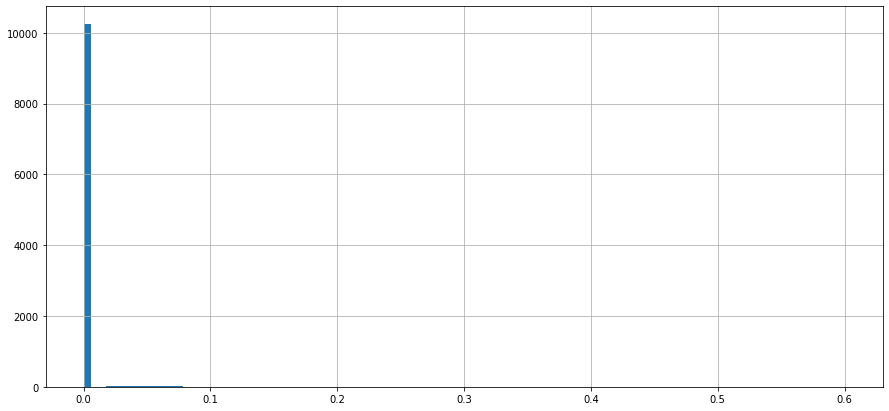

In [6]:
df_refsec_cross_ling_ratios[df_refsec_cross_ling_ratios.refsec_size >= 2].cross_ling_ratio.hist(bins=100, figsize=(15,7))

In [128]:
# load in arXiv metadata
# (takes quite a bit of time)

dparser = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')
df_mtd = pd.read_csv(
    'in_lang_cleaned_extended.tsv',
    header=None,
    names = ['uuid', 'lang', 'aid', 'published', 'category', 'journal_ref', 'bibitem_str'],
    sep='\t',
    parse_dates=['published'],
    date_parser=dparser,
    low_memory=False,
    quoting=csv.QUOTE_NONE
)
disc_map = {  # see: https://arxiv.org/category_taxonomy
    'math': 'math',
    'cond-mat': 'phys',
    'math-ph': 'phys',
    'physics': 'phys',
    'cs': 'cs',
    'hep-th': 'phys',
    'nlin': 'phys',
    'gr-qc': 'phys',
    'hep-ph': 'phys',
    'astro-ph': 'phys',
    'quant-ph': 'phys',
    'nucl-th': 'phys',
    'q-fin': 'other',
    'hep-ex': 'phys',
    'stat': 'other',
    'nucl-ex': 'phys',
    'q-alg': 'math',
    'q-bio': 'other',
    'solv-int': 'phys',
    'chao-dyn': 'phys',
    'hep-lat': 'phys',
    'funct-an': 'math',
    'patt-sol': 'phys',
    'dg-ga': 'other',
    'alg-geom': 'math',
    'cmp-lg': 'cs',
    'adap-org': 'phys',
    'econ': 'other',
    'eess': 'other',
    'acc-phys': 'phys',
    'comp-gas': 'cs'
}

ppr_category = pd.Series(dtype=str, name='category')
ppr_published = pd.Series(dtype='datetime64[ns]', name='published')
for rovv in df_mtd.iterrows():
    row = rovv[1]
    ppr_category.at[row.aid] = disc_map[row.category.split('.')[0]]
    ppr_published.at[row.aid] = row.published

# df_mtd['category'] = df_mtd['category'].apply(lambda x: disc_map[x.split('.')[0]])
# 
# df_pubcat = df_mtd[['aid', 'published', 'category']].groupby('aid').agg(
#     {'published': lambda x: x,
#      'category': lambda x: x}
# )
# df_mtd[['aid', 'published', 'category']][df_mtd.aid == 'solv-int9912011']
# df_pubcat.reset_index()

In [129]:
# extend
df_refsec_cross_ling_ratios_ext = pd.concat(
    [refsec_sizes,
     refsec_cross_ling_ratios,
     ppr_category,
     ppr_published], axis=1
)
df_refsec_cross_ling_ratios_ext

,refsec_size,cross_ling_ratio,category,published
0704.0046,13,0.076923,phys,2007-04-01 16:37:36
0704.0091,22,0.045455,math,2007-04-01 15:17:36
0704.0130,40,0.025000,math,2007-04-02 06:25:15
0704.0180,15,0.066667,phys,2007-04-02 12:40:00
0704.0260,9,0.111111,math,2007-04-03 19:16:48
...,...,...,...,...
solv-int9910002,7,0.285714,phys,1999-10-08 07:40:53
solv-int9910008,15,0.066667,phys,1999-10-18 16:16:47
solv-int9912010,23,0.043478,phys,1999-12-15 19:15:16
solv-int9912011,5,0.600000,phys,1999-12-16 16:05:14


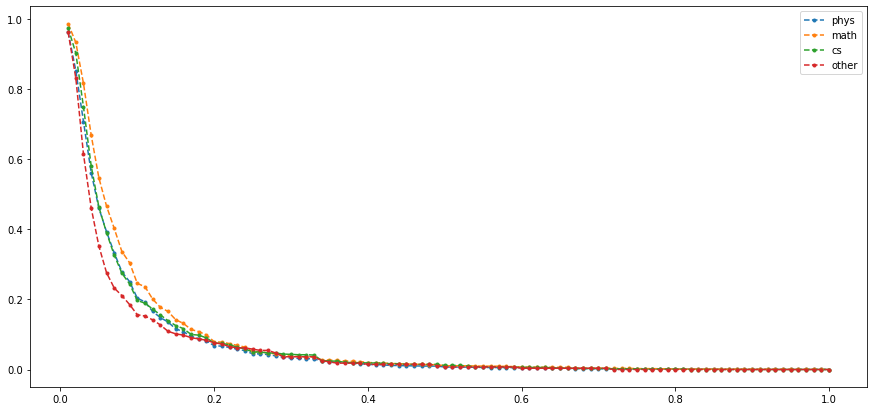

In [202]:
# calculate cross linguality level cross-section across domains

total_cat_counts = df_refsec_cross_ling_ratios_ext.category.value_counts().to_dict()

phys_cross_ling_ratios = pd.Series(dtype=float, name='phys')
math_cross_ling_ratios = pd.Series(dtype=float, name='math')
cs_cross_ling_ratios = pd.Series(dtype=float, name='cs')
other_cross_ling_ratios = pd.Series(dtype=float, name='other')
cross_ling_ratios = {
    'phys': phys_cross_ling_ratios,
    'math': math_cross_ling_ratios,
    'cs': cs_cross_ling_ratios,
    'other': other_cross_ling_ratios
}

for min_ratio in range(1, 101, 1):
    min_r = min_ratio / 100
    very_cross_ling_cat_counts = df_refsec_cross_ling_ratios_ext[
        (df_refsec_cross_ling_ratios_ext.refsec_size > 2) & \
        (df_refsec_cross_ling_ratios_ext.cross_ling_ratio > min_r)].category.value_counts().to_dict()
    for disc in set(disc_map.values()):
        cross_ling_ratios[disc].at[min_r] = very_cross_ling_cat_counts.get(disc, 0) / total_cat_counts[disc]
df_refsec_cross_ling_crosssecs = pd.concat(
    [phys_cross_ling_ratios,
    math_cross_ling_ratios,
    cs_cross_ling_ratios,
    other_cross_ling_ratios], axis=1
)
# xlabel: relative number of documents in category
# ylabel: filter ratio of cross-lingual citations
plt = df_refsec_cross_ling_crosssecs.plot(kind='line', marker='.', style='--', figsize=(15,7))